In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))
        ])

train = datasets.MNIST('./data/tr', train=True, transform=transform, download=True)
test = datasets.MNIST('./data/t', train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(train, batch_size=32)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 55454984.85it/s]


Extracting ./data/tr/MNIST/raw/train-images-idx3-ubyte.gz to ./data/tr/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1552643.51it/s]


Extracting ./data/tr/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/tr/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13512298.02it/s]


Extracting ./data/tr/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/tr/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2183691.97it/s]

Extracting ./data/tr/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/tr/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 52047059.06it/s]


Extracting ./data/t/MNIST/raw/train-images-idx3-ubyte.gz to ./data/t/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1546399.95it/s]


Extracting ./data/t/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/t/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13930746.82it/s]


Extracting ./data/t/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/t/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3079122.15it/s]

Extracting ./data/t/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/t/MNIST/raw



In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [4]:
def noise(batch_size=1):
    return torch.rand((batch_size, 128))

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

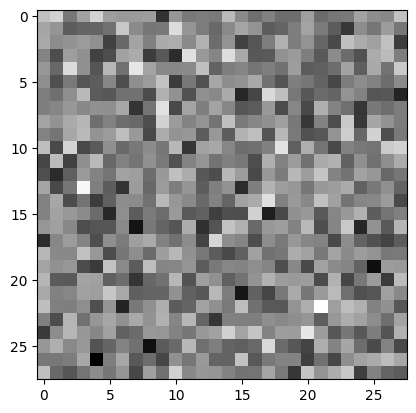

In [6]:
#train the discriminator

dis = Discriminator()
dis.to('cuda:0')

optimizer_d = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0001)
lossfn = nn.BCELoss()


#gen
gen = Generator()
gen.to('cuda:0')

optimizer_g = torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=0.0001)

gen.eval()
plt.imshow(gen(noise(1).to('cuda:0')).reshape(28,28).detach().cpu().numpy(), 'gray')

In [7]:
dl = []
gl = []
n_epochs = 20
device = 'cuda:0'
batch_size=64

dis.train()
gen.train()

for ep in range(n_epochs):
    gen_loss, dis_loss = 0, 0
    for idx, (real_data, _) in enumerate(trainloader):
        # Train discriminator
        real_data = real_data.to(device)
        real_labels = torch.ones((real_data.size(0), 1)).to(device)
        fake_labels = torch.zeros((real_data.size(0), 1)).to(device)

        optimizer_d.zero_grad()

        # Discriminator on real data
        output_real = dis(real_data)
        loss_real = lossfn(output_real, real_labels)

        # Generate fake data
        noise_batch = noise(real_data.size(0)).to(device)
        fake_data = gen(noise_batch)
        
        # Discriminator on fake data
        output_fake = dis(fake_data.detach())  # Detach to avoid computing gradients for generator
        loss_fake = lossfn(output_fake, fake_labels)

        # Total discriminator loss
        loss_d = (loss_real + loss_fake) / 2  # Average of real and fake loss
        dis_loss += loss_d.item()

        loss_d.backward()
        optimizer_d.step()

        # Train generator
        optimizer_g.zero_grad()

        noise_batch = noise(batch_size).to(device)
        gen_data = gen(noise_batch)
        output = dis(gen_data)

        # Generator wants the discriminator to classify its samples as real (i.e., 1)
        labels_g = torch.ones((gen_data.size(0), 1)).to(device)
        loss_g = lossfn(output, labels_g)
        gen_loss += loss_g.item()

        loss_g.backward()
        optimizer_g.step()

    dl.append(dis_loss)
    gl.append(gen_loss)
    print(ep, dis_loss, gen_loss)
    
    #AAAAAAAAAAAA
    #https://colab.research.google.com/drive/1z_FMeliNoAqpCwf6-EVa-m0wOYPwlSrt?usp=sharing

0 448.1492913495749 7630.74998575449
1 340.81198569154367 7544.9018856287
2 351.7522832369432 7383.189549207687
3 403.8024733606726 7537.4001977443695
4 515.9679734366946 7660.812055885792
5 432.1224997267127 7625.158109545708
6 446.7592903468758 7332.702213525772
7 413.86760793812573 7257.152494668961
8 415.2977226357907 7214.147469162941
9 426.48582762107253 6942.243474245071
10 444.6130016539246 6753.14824450016
11 454.14358450844884 6332.482626199722
12 412.40401566773653 6613.840381860733
13 407.1279643960297 6699.426481962204
14 405.6988062374294 6903.306715011597
15 384.2330833990127 6875.258836269379
16 393.99142612703145 6774.611093759537
17 384.6988980732858 6688.010506033897
18 442.3814803138375 6426.4309067726135
19 386.83888517320156 6544.7121859788895


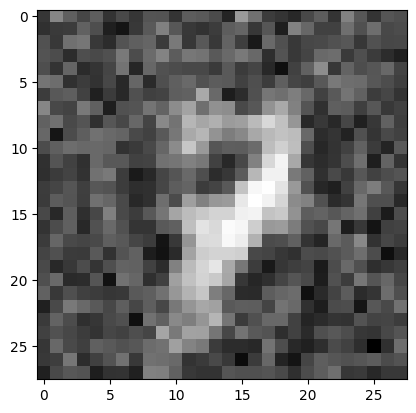

In [13]:
gen.eval()
plt.imshow(gen(noise(1).to('cuda:0')).reshape(28,28).detach().cpu().numpy(), 'gray')

In [9]:
len(train) / 64

937.5